# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Установим и импортируем необходимые библиотеки.

In [1]:
# !pip install pandas_profiling --user 

In [2]:
#!pip install --upgrade pandas --user 

In [3]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet

import warnings
warnings.filterwarnings("ignore")

In [4]:
pd.__version__

'1.3.4'

## Подготовка данных

### Загрузка данных

Загрузим данные, предусмотрим различные способы расположения файлов.

In [5]:
try:
    autos = pd.read_csv('autos.csv')
except:
    autos = pd.read_csv('/datasets/autos.csv')

Проверим читаемость данных.

In [6]:
autos.sample(5).T

,232024,254731,268110,184521,313646
DateCrawled,2016-03-07 12:56:10,2016-04-03 18:47:37,2016-03-18 21:42:49,2016-03-07 00:37:33,2016-03-08 19:57:36
Price,3999,900,14999,9500,6900
VehicleType,wagon,NaN,bus,wagon,small
RegistrationYear,1999,2017,2011,2011,2010
Gearbox,NaN,manual,auto,manual,manual
Power,110,75,140,131,101
Model,a4,megane,touran,megane,yaris
Kilometer,150000,150000,70000,125000,40000
RegistrationMonth,10,10,2,1,8
FuelType,gasoline,NaN,petrol,gasoline,petrol


Описание данных

Признаки

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

Целевой признак

    Price — цена (евро)

Данные читаемы, описанию соответствуют.

In [7]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Приведем признаки к соответствующему типу данных.

    DateCrawled — дата скачивания анкеты из базы
    DateCreated — дата создания анкеты
    LastSeen — дата последней активности пользователя

In [8]:
FORMAT_DATETIME = '%Y-%m-%dT%H:%M:%S'

In [9]:
date_features = ['DateCrawled', 'DateCreated', 'LastSeen']

In [10]:
for date_feature in date_features:
    autos[date_feature] = pd.to_datetime(autos[date_feature], format=FORMAT_DATETIME)

### EDA средствами pandas-profiling

С помощью средств библиотеки pandas_profiling проанализируем данные.

In [11]:
# profile = autos.profile_report()

In [12]:
# profile.to_notebook_iframe()

1. Данные скачивались чуть больше месяца: с 2016-03-05 14:06:22 по 2016-04-07 14:36:58.
2. В графе Price 3.0% (10772) объектов имеют нулевую стоимость.
3. VehicleType - пропуски 10.6% (37 490)
4. RegistrationYear есть неправдоподобно малые и большие значения
5. Gearbox - пропуски 5.6% (19 833)
6. Power есть неправдоподобно малые и большие значения
7. Model - пропуски 5.6% (19 705)
8. FuelType - пропуски 9.3% (32 895)
9. NotRepaired - пропуски 20.1% (71 154)
10. NumberOfPictures - все значения 0

### Предобработка

<a id="drop_duplicates"></a>
Удалим дубли.

In [13]:
autos.drop_duplicates(inplace=True)

Напишем функцию для замещения пропусков.

In [14]:
def fill_mode(column):
    
    use_columns = groupby_columns.copy()
    use_columns.remove(column)
    
    for i in range(1, len(use_columns)):
        
        autos[column] = (
            autos.groupby(use_columns[:-i])[column]
            .transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else np.nan)))
        )

In [15]:
groupby_columns = ["Brand", "Model", "VehicleType", "Power", "RegistrationYear", "Gearbox", "FuelType", "kostyl'"]

Приравняем нули в графе 'Power' к пропускам.

In [16]:
autos.loc[autos['Power']==0, ['Power']] = np.nan

С помощью функции fill_mode заполним пропуски в выбраных столбцах.

In [17]:
fill_columns = ["VehicleType", "Gearbox", "FuelType", "Model", "Power", ]

In [18]:
%%time
for col in fill_columns:
    fill_mode(col)

Wall time: 4min 51s


В графе 'NotRepaired' заменим пропуски значением 'unknown'.

In [19]:
autos['NotRepaired'].fillna('unknown', inplace=True)

Неправдоподобно малые и большие значения в графе "RegistrationYear" заменим модой.

In [20]:
autos.loc[(autos["RegistrationYear"] < 1950) | (autos["RegistrationYear"] > 2022)].shape[0]

351

In [21]:
autos.loc[(autos["RegistrationYear"] < 1950) | (autos["RegistrationYear"] > 2022), "RegistrationYear"] = (
    autos["RegistrationYear"].mode()
)

<code>[Учитывая систему почтовых кодов США](https://en.wikipedia.org/wiki/ZIP_Code)</code> - в графе "PostalCode"оставляем только первую цифру.

<a id="ZIP_code_zones"></a>
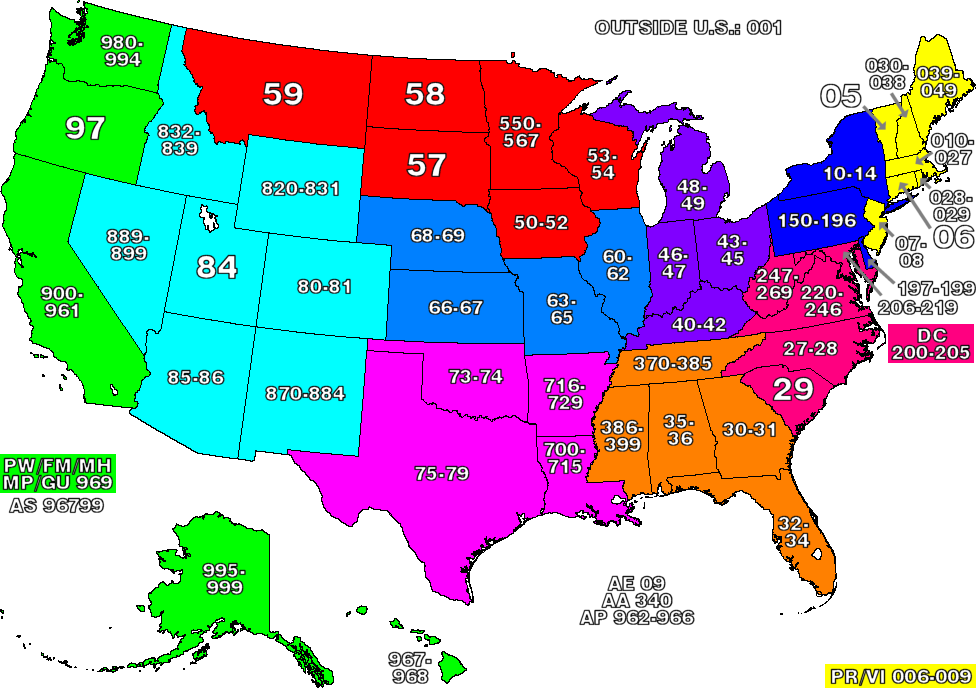

In [22]:
autos['PostalCode'] = autos['PostalCode'] // 10_000

Избавимся от объектов с ценой 0.

In [23]:
autos = autos.loc[autos["Price"] > 0]

Удалим признаки, не содержащие полезной информации.

In [24]:
autos = autos.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures'], axis=1)

Неправдоподобно малые и большие значения в графе "Power" заменим модой.

In [25]:
autos.loc[(autos["Power"] < 30) | (autos["Power"] > 500)].shape[0]

1391

In [26]:
autos.loc[(autos["Power"] < 30) | (autos["Power"] > 500), "Power"] = (
    autos["Power"].mode()
)

Избавимся от объектов с пропусками, обновим индексы.

In [27]:
autos = autos.dropna().reset_index()

### Проверка

Проверим результат проведенных преобразований.

In [28]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339188 entries, 0 to 339187
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              339188 non-null  int64  
 1   Price              339188 non-null  int64  
 2   VehicleType        339188 non-null  object 
 3   RegistrationYear   339188 non-null  float64
 4   Gearbox            339188 non-null  object 
 5   Power              339188 non-null  float64
 6   Model              339188 non-null  object 
 7   Kilometer          339188 non-null  int64  
 8   RegistrationMonth  339188 non-null  int64  
 9   FuelType           339188 non-null  object 
 10  Brand              339188 non-null  object 
 11  NotRepaired        339188 non-null  object 
 12  PostalCode         339188 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 33.6+ MB


In [29]:
# profile_2 = autos.profile_report()

In [30]:
# profile_2.to_notebook_iframe()

Пропусков нет, распределения правдоподобны.

### Вывод

Предоставленные данные содержат информацию по 354 369 объектам, распределенную по 16 признакам.

Исследовательский анализ данных показал, что имеются несоответствующие типы данных, пропуски, нулевые, неправдоподобно малые и большие значения, а также признаки, не несущие информации.

В результате проведенной предобработки выявленные недостатки были устранены, итоговый датасет состоит из 339 192 объектов и 12 признаков, не имеет пропусков, значения распределены правдоподобно.

Предварительно можно сделать вывод о том, что количество и качество данных достаточны для целей исследования.

## Обучение моделей

Подготовим таблицу для занесения результатов.

In [31]:
results = pd.DataFrame()

### Проверка на вменяемость

In [32]:
result_dummy = ['dummy']

Вычислим rmse для среднего значения целевого признака.

In [33]:
features = autos.drop(['Price'], axis=1)
target = autos['Price']
print(features.shape, target.shape)

(339188, 12) (339188,)


In [34]:
y_true = target

In [35]:
start_time = time.perf_counter()
target_mean = target.mean()
result_dummy.append(time.perf_counter() - start_time)

In [36]:
start_time = time.perf_counter()
y_pred = pd.Series(target_mean, index=target.index)
result_dummy.append(time.perf_counter() - start_time)

In [37]:
rmse = mean_squared_error(y_true, y_pred, squared=False)
result_dummy.append(rmse)
results = results.append([result_dummy], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_dummy))

model: dummy, fit_time: 0.001, predict_time: 0.002, rmse: 4504


### Кодировка признаков для моделей на основе линейной регрессии

Для обучения для моделей на основе линейной регрессии выполним кодирование категориальных признаков методом OneHotEncoding.

In [38]:
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']

In [39]:
%%time

features_ohe = pd.get_dummies(features[categorical_features], drop_first=True)

Wall time: 724 ms


In [40]:
X_train_ohe, X_test_ohe, Y_train, Y_test = train_test_split(features_ohe, target, test_size=0.25, random_state=12345)

print("Размеры Train_ohe/Test_ohe: ", X_train_ohe.shape, X_test_ohe.shape, Y_train.shape, Y_test.shape)

Размеры Train_ohe/Test_ohe:  (254391, 303) (84797, 303) (254391,) (84797,)


<a id="scaled"></a>
Выполним масштабирование признаков.

In [41]:
%%time

scaler = StandardScaler()
scaler.fit(X_train_ohe)
X_train_scaled = scaler.transform(X_train_ohe)
X_test_scaled = scaler.transform(X_test_ohe)

Wall time: 2.62 s


### LinearRegression

Для обучения алгоритмом LinearRegression() подбор гиперпараметров не потребуется.

In [42]:
result_linear_regression = ['linear_regression']

In [43]:
linear_regression = LinearRegression()

In [44]:
start_time = time.perf_counter()
linear_regression.fit(X_train_ohe, Y_train)
result_linear_regression.append(time.perf_counter() - start_time)

In [45]:
start_time = time.perf_counter()
y_pred_test = linear_regression.predict(X_test_ohe)
result_linear_regression.append(time.perf_counter() - start_time)

In [46]:
rmse = mean_squared_error(Y_test, y_pred_test, squared=False)
result_linear_regression.append(rmse)
results = results.append([result_linear_regression], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_linear_regression))

model: linear_regression, fit_time: 6.024, predict_time: 0.256, rmse: 3518


<a id="linear_regression_scaled"></a>
Проделаем то же самое с масштабированными признаками.

In [47]:
result_linear_regression_scaled = ['linear_regression_scaled']

In [48]:
linear_regression_scaled = LinearRegression()

In [49]:
start_time = time.perf_counter()
linear_regression_scaled.fit(X_train_scaled, Y_train)
result_linear_regression_scaled.append(time.perf_counter() - start_time)

In [50]:
start_time = time.perf_counter()
y_pred_test = linear_regression_scaled.predict(X_test_scaled)
result_linear_regression_scaled.append(time.perf_counter() - start_time)

In [51]:
rmse = mean_squared_error(Y_test, y_pred_test, squared=False)
result_linear_regression_scaled.append(rmse)
results = results.append([result_linear_regression_scaled], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_linear_regression_scaled))

model: linear_regression_scaled, fit_time: 5.062, predict_time: 0.050, rmse: 3518


Использование StandardScaler() не улучшает точность предсказания LinearRegression()

Результаты работы LinearRegression():

- качество предсказания RMSE: 3530
- скорость предсказания Wall time: 230 ms
- время обучения Wall time: 5.28 s

### Ridge

Для алгоритма Ridge() выполним подбор оптимальных гиперпараметров.

In [52]:
result_ridge = ['ridge']

In [53]:
ridge = Ridge()

In [54]:
parametrs = {'alpha': [0.05, 0.2, 0.99]}

In [55]:
%%time

ridge_grid = GridSearchCV(ridge, parametrs, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train_ohe, Y_train)
best_ridge = ridge_grid.best_estimator_
ridge_grid.best_params_

Wall time: 24.9 s


{'alpha': 0.05}

Замерим показатели модели с оптимальными гиперпараметрами.

In [56]:
start_time = time.perf_counter()
best_ridge.fit(X_train_ohe, Y_train)
result_ridge.append(time.perf_counter() - start_time)

In [57]:
start_time = time.perf_counter()
y_pred_test = best_ridge.predict(X_test_ohe)
result_ridge.append(time.perf_counter() - start_time)

In [58]:
rmse = mean_squared_error(Y_test, y_pred_test, squared=False)
result_ridge.append(rmse)
results = results.append([result_ridge], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_ridge))

model: ridge, fit_time: 1.643, predict_time: 0.289, rmse: 3518


<a id="ridge_scaled"></a>
Проделаем то же самое с масштабированными признаками.

In [59]:
result_ridge_scaled = ['ridge_scaled']

In [60]:
ridge_scaled = Ridge(alpha=0.05)

In [61]:
start_time = time.perf_counter()
ridge_scaled.fit(X_train_scaled, Y_train)
result_ridge_scaled.append(time.perf_counter() - start_time)

In [62]:
start_time = time.perf_counter()
y_pred_test = ridge_scaled.predict(X_test_scaled)
result_ridge_scaled.append(time.perf_counter() - start_time)

In [63]:
rmse = mean_squared_error(Y_test, y_pred_test, squared=False)
result_ridge_scaled.append(rmse)
results = results.append([result_ridge_scaled], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_ridge_scaled))

model: ridge_scaled, fit_time: 1.316, predict_time: 0.218, rmse: 3518


Использование StandardScaler() не улучшает точность предсказания Ridge(). Почему?

Результаты работы Ridge():

- качество предсказания RMSE: 3530
- скорость предсказания Wall time: 227 ms
- время обучения Wall time: 1.32 s

### ElasticNet

Для алгоритма ElasticNet() выполним подбор оптимальных гиперпараметров.

In [64]:
result_elastic = ['elastic']

In [65]:
elastic = ElasticNet() 

In [66]:
%%time

elastic_grid = GridSearchCV(elastic, parametrs, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
elastic_grid.fit(X_train_ohe, Y_train)
best_elastic = elastic_grid.best_estimator_
elastic_grid.best_params_

Wall time: 40.2 s


{'alpha': 0.05}

Замерим показатели модели с оптимальными гиперпараметрами.

In [67]:
start_time = time.perf_counter()
best_elastic.fit(X_train_ohe, Y_train)
result_elastic.append(time.perf_counter() - start_time)

In [68]:
start_time = time.perf_counter()
y_pred_test = best_elastic.predict(X_test_ohe)
result_elastic.append(time.perf_counter() - start_time)

In [69]:
rmse = mean_squared_error(Y_test, y_pred_test, squared=False)
result_elastic.append(rmse)
results = results.append([result_elastic], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_elastic))

model: elastic, fit_time: 5.071, predict_time: 0.224, rmse: 3753


<a id="elastic_scaled"></a>
Проделаем то же самое с масштабированными признаками.

In [70]:
result_elastic_scaled = ['elastic_scaled']

In [71]:
elastic_scaled = ElasticNet(alpha=0.05)

In [72]:
start_time = time.perf_counter()
elastic_scaled.fit(X_train_scaled, Y_train)
result_elastic_scaled.append(time.perf_counter() - start_time)

In [73]:
start_time = time.perf_counter()
y_pred_test = elastic_scaled.predict(X_test_scaled)
result_elastic_scaled.append(time.perf_counter() - start_time)

In [74]:
rmse = mean_squared_error(Y_test, y_pred_test, squared=False)
result_elastic_scaled.append(rmse)
results = results.append([result_elastic_scaled], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_elastic_scaled))

model: elastic_scaled, fit_time: 27.501, predict_time: 0.109, rmse: 3522


Использование StandardScaler() не улучшает точность предсказания ElasticNet(). Почему?

Результаты работы ElasticNet():

- качество предсказания RMSE: 3766
- скорость предсказания Wall time: 206 ms
- время обучения Wall time: 3.95 s

### LightGBM

Для обучения для моделей на основе решающих деревьев выполним кодирование категориальных признаков методом LabelEncoding.

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

print("Размеры Train/Test: ", X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Размеры Train/Test:  (254391, 12) (84797, 12) (254391,) (84797,)


In [76]:
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']

In [77]:
ordinal_encoder = OrdinalEncoder()

In [78]:
ordinal_encoder.fit(X_train[categorical_features])

OrdinalEncoder()

In [79]:
X_train[categorical_features] = ordinal_encoder.transform(X_train[categorical_features])

In [80]:
X_test[categorical_features] = ordinal_encoder.transform(X_test[categorical_features])

Для алгоритма LGBMRegressor() выполним подбор оптимальных гиперпараметров.

In [81]:
result_lgb_regressor = ['lgb_regressor']

In [82]:
lgb_regressor = lgb.LGBMRegressor()

In [83]:
parametrs = {'boosting_type': ['gbdt', 'dart', 'goss'],
             'learning_rate': [.05, .1, .5, 1., 5.],
             'n_estimators': [10, 100] }

In [84]:
%%time

lgb_regressor_grid = GridSearchCV(lgb_regressor, parametrs, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgb_regressor_grid.fit(X_train, Y_train)
best_lgb_regressor = lgb_regressor_grid.best_estimator_
lgb_regressor_grid.best_params_

Wall time: 1min 50s


{'boosting_type': 'dart', 'learning_rate': 0.5, 'n_estimators': 100}

Замерим показатели модели с оптимальными гиперпараметрами.

In [85]:
start_time = time.perf_counter()
best_lgb_regressor.fit(X_train, Y_train)
result_lgb_regressor.append(time.perf_counter() - start_time)

In [86]:
start_time = time.perf_counter()
y_pred_test = best_lgb_regressor.predict(X_test)
result_lgb_regressor.append(time.perf_counter() - start_time)

In [87]:
rmse = mean_squared_error(Y_test, y_pred_test, squared=False)
result_lgb_regressor.append(rmse)
results = results.append([result_lgb_regressor], ignore_index=True)
print('model: {}, fit_time: {:.3f}, predict_time: {:.3f}, rmse: {:.0f}'.format(*result_lgb_regressor))

model: lgb_regressor, fit_time: 2.659, predict_time: 0.189, rmse: 1704


Результаты работы LGBMRegressor():

- качество предсказания RMSE: 1698
- скорость предсказания Wall time: 223 ms
- время обучения Wall time: 2.64 s

## Анализ моделей

Обобщим полученные результаты в таблице.

In [88]:
results.columns=['model', 'fit_time', 'predict_time', 'rmse']

In [89]:
results.style.format({'fit_time': '{:.3f}', 'predict_time': '{:.3f}', 'rmse': '{:.0f}'})

,model,fit_time,predict_time,rmse
0,dummy,0.001,0.002,4504
1,linear_regression,6.024,0.256,3518
2,linear_regression_scaled,5.062,0.050,3518
3,ridge,1.643,0.289,3518
4,ridge_scaled,1.316,0.218,3518
5,elastic,5.071,0.224,3753
6,elastic_scaled,27.501,0.109,3522
7,lgb_regressor,2.659,0.189,1704


Результаты работы LinearRegression():

- качество предсказания RMSE: 3530
- скорость предсказания Wall time: 230 ms
- время обучения Wall time: 5.28 s

Результаты работы Ridge():

- качество предсказания RMSE: 3530
- скорость предсказания Wall time: 227 ms
- время обучения Wall time: 1.32 s

Результаты работы ElasticNet():

- качество предсказания RMSE: 3766
- скорость предсказания Wall time: 206 ms
- время обучения Wall time: 3.95 s

Результаты работы LGBMRegressor():

- качество предсказания RMSE: 1698
- скорость предсказания Wall time: 223 ms
- время обучения Wall time: 2.64 s

По качеству предсказания по метрике RMSE с подавляющим преимуществом выигрывает алгоритм градиентного бустинга LGBMRegressor().

Скорость предсказания приблизительно одинакова у всех исследованных моделей.

По времени обучения лидер Ridge(), вдвое дольше обучалась модель LGBMRegressor(), в три раза дольше обучалась модель ElasticNet(), модель LinearRegression() - в 4 раза дольше.

## Вывод

Учитывая результаты исследования, можем рекомендовать для использования в разрабатываемом приложении две модели определения стоимости:
- на основе алгоритма LGBMRegressor(), если приоритетом является точность прогноза,
- на основе алгоритма Ridge(), если приоритетом является скорость работы.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей